In [4]:
from src.crawler.base_crawler import BaseCrawler
from bs4 import BeautifulSoup
import pandas as pd
from pprint import pprint
import re
import json
import os
from PIL import Image

各映画のサイトからpdで特徴をとる.(画像も保存.)

In [12]:

di="data/Feature_data"
idi="data/image"
jidi="../../Wang Zeyu/"

def load_image(file_name,idi=idi):
    try:
        im = Image.open(idi+"/"+file_name+".jpg")
        return im
    except Exception as e:
        print(e,"please load image of "+file_name)

class Feature_Crawler(BaseCrawler):
    def __init__(self,start=0,last=0,order_list=None,order_name=None,di=di,idi=idi):
        super().__init__()
        self.idi=idi
        self.di=di
        self.start=start
        self.last=last
        self.order_list=order_list
        self.order_name=order_name
        #欲しい特徴の名前(title, 画像, story)
        self.feature_list=["titleId",'image_exist',"story_line"]
        # (その他)
        self.all_feature=['@context', '@type', 'url', 'name', 'image', 'genre', 'contentRating', 'actor','director','creator', 'description', 'datePublished', 'keywords', 'aggregateRating', 'review','duration','trailer']
        self.feature_list.extend(self.all_feature)
        self.load_csv()
        

    def get_feature(self, movie_id):
        try:
            os.makedirs(self.idi)
        except FileExistsError:
            pass
        res = self.get_response('https://www.imdb.com/title/' + movie_id + '/')
        soup = BeautifulSoup(markup=res.content, features='html.parser')
        try:
            json_data = soup.find('script', {'type' : 'application/ld+json'})
        except Exception as e:
            return None
            
        parsed_json = json.loads(json_data.contents[0])
        kind = soup.find("a",href="/search/title?genres=movie&explore=title_type,genres")
        
        if parsed_json["@type"]=="Movie":
            #欲しい特徴を得る処理(名前と順を揃える)
            features=[]

            #画像


            img_url = parsed_json.get('image')

            try:
                res_img = self.get_response(img_url)
                self.save_image(movie_id,res_img)
            except Exception as e:
                img_url=None

            features.append(img_url)

            #story
            story_data=soup.find("div",{'class':"inline canwrap"})
            if story_data is None:
                story=None
            else:
                story=story_data.getText()

            features.append(story)

            #その他
            print(movie_id,parsed_json.keys())
            for name in self.all_feature:
                try:
                    features.append(parsed_json[name])
                except Exception as e:
                    features.append(None)

            return features
        else:
            return None
    
    def save_image(self, file_name, res_img):
        if not os.path.exists(self.idi+"/"+file_name+".jpg"):
            try:
                with open(self.idi+"/"+file_name+".jpg", 'wb') as img_file:
                    img_file.write(res_img.content)
                print('Save image for ' + file_name)
            except Exception as e:
                print('Saving image failure for ' + file_name)   
            
    def movie_num(self,n):
        return "tt"+(7-len(str(n)))*"0"+str(n)
    
    @property
    def feature_di(self):
        if self.order_name is None:
            return self.di+"/"+"_".join(self.feature_list)+"_s"+str(self.start)+"_l"+str(self.last)+".csv"
        else:
            return self.di+"/"+"_".join(self.feature_list)+"_n"+self.order_name+".csv"
    
    def save_as_csv(self):
        try:
            os.makedirs(self.di)
        except FileExistsError:
            pass
        pd_list=[]
        search=None
        if self.order_name is None:
            search=range(self.start,self.last+1,1)
        else:
            search=self.order_list
            
        for i in search:
            if self.order_name is None:
                movie_id=self.movie_num(i)
            else:
                movie_id=i
            feature=self.get_feature(movie_id)
            id_feature=[movie_id]
            if feature !=  None:
                id_feature.extend(feature)
                pd_list.append(id_feature)
        
        pd_list=pd.DataFrame(pd_list,columns=self.feature_list)
        #pd_list
        pd_list.to_csv(self.feature_di)
        
        return pd_list
    
    
    def load_csv(self):
        if not os.path.exists(self.feature_di):
            self.save_as_csv()
        self.feature=pd.read_csv(self.feature_di,index_col=1)
        self.feature=self.feature.drop('Unnamed: 0',axis=1)   
       
        
fea = Feature_Crawler(1,2)
fea.feature

,image_exist,story_line,@context,@type,url,name,image,genre,contentRating,actor,director,creator,description,datePublished,keywords,aggregateRating,review,duration,trailer
titleId,,,,,,,,,,,,,,,,,,,
tt0000001,https://m.media-amazon.com/images/M/MV5BZmUzOW...,"\n\n Presumably, the first woman ever to ap...",http://schema.org,Movie,/title/tt0000001/,Carmencita,https://m.media-amazon.com/images/M/MV5BZmUzOW...,"['Documentary', 'Short']",Not Rated,"{'@type': 'Person', 'url': '/name/nm1588970/',...","{'@type': 'Person', 'url': '/name/nm0005690/',...","{'@type': 'Organization', 'url': '/company/co0...",Carmencita is a short starring Carmencita. Per...,1894-03-10,"dance,dancer,music hall,kinetoscope,actress","{'@type': 'AggregateRating', 'ratingCount': 16...","{'@type': 'Review', 'itemReviewed': {'@type': ...",PT1M,NaN
tt0000002,https://m.media-amazon.com/images/M/MV5BZDI4ZD...,\n\n Short film of 300 individually painted...,http://schema.org,Movie,/title/tt0000002/,Le clown et ses chiens,https://m.media-amazon.com/images/M/MV5BZDI4ZD...,"['Animation', 'Short']",NaN,NaN,"{'@type': 'Person', 'url': '/name/nm0721526/',...",NaN,NaN,1892-10-28,"dog,clown","{'@type': 'AggregateRating', 'ratingCount': 20...",NaN,PT5M,NaN


画像を取り出す.

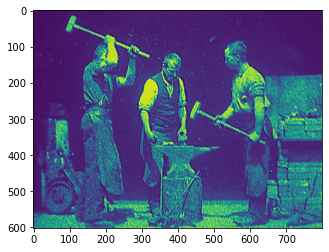

In [13]:
import numpy as np
import matplotlib.pyplot as plt

image=load_image("tt0000005")
plt.imshow(np.array(image))